<a href="https://colab.research.google.com/github/nisha1365/THINK-BAYES/blob/main/Chapter_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !pip install empiricaldist

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for empiricaldist: filename=empiricaldist-0.6.7-py3-none-any.whl size=11972 sha256=d7908dd1e4b7ee221d4e3fa6cd0d14248bf52198f7e17c3ca4792f029beab684
  Stored in directory: /root/.cache/pip/wheels/dd/dc/1c/c472efa84814edbb5b67d132ad3950534d0d7fd808543a659c
Successfully built empiricaldist


In [ ]:
# Get utils.py

from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)
    
download('https://github.com/AllenDowney/ThinkBayes2/raw/master/soln/utils.py')

Downloaded utils.py


In [ ]:
from utils import set_pyplot_params
set_pyplot_params()

The Euro Problem


When spun on edge 250 times, a Belgian one-euro coin came up heads 140 times and tails 110. `It looks very suspicious to me,' said Barry Blight, a statistics lecturer at the London School of Economics. `If the coin were unbiased, the chance of getting a result as extreme as that would be less than 7%.'

To answer that question, we'll proceed in two steps. First we'll use the binomial distribution to see where that 7% came from; then we'll use Bayes's Theorem to estimate the probability that this coin comes up heads.



The Binomial Distribution

Suppose I tell you that a coin is "fair", that is, the probability of heads is 50%. If you spin it twice, there are four outcomes: HH, HT, TH, and TT. All four outcomes have the same probability, 25%.

We could evaluate this expression ourselves, but we can also use the SciPy function binom.pmf. For example, if we flip a coin n=2 times and the probability of heads is p=0.5, here's the probability of getting k=1 heads:

In [ ]:
from scipy.stats import binom

n = 2
p = 0.5
k = 1

binom.pmf(k, n, p)

0.5000000000000002

Instead of providing a single value for k, we can also call binom.pmf with an array of values.

In [ ]:
import numpy as np
ks = np.arange(n+1)

ps = binom.pmf(ks, n, p)
ps

array([0.25, 0.5 , 0.25])

In [ ]:
from empiricaldist import Pmf

pmf_k = Pmf(ps, ks)
pmf_k

,probs
0,0.25
1,0.50
2,0.25


The following function computes the binomial distribution for given values of n and p and returns a Pmf that represents the result.

In [ ]:
def make_binomial(n, p):
    """Make a binomial Pmf."""
    ks = np.arange(n+1)
    ps = binom.pmf(ks, n, p)
    return Pmf(ps, ks)

Here's what it looks like with n=250 and p=0.5:

In [ ]:
pmf_k = make_binomial(n=250, p=0.5)

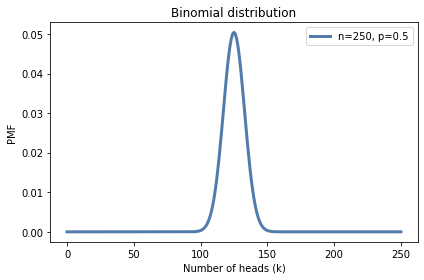

In [ ]:
from utils import decorate

pmf_k.plot(label='n=250, p=0.5')

decorate(xlabel='Number of heads (k)',
         ylabel='PMF',
         title='Binomial distribution')

The most likely quantity in this distribution is 125:

In [ ]:
pmf_k.max_prob()

125

But even though it is the most likely quantity, the probability that we get exactly 125 heads is only about 5%.

In [ ]:
pmf_k[125]


0.050412213147309655

In MacKay's example, we got 140 heads, which is even less likely than 125:

In [ ]:
pmf_k[140]

0.008357181724918204

In [ ]:
def prob_ge(pmf, threshold):
    """Probability of quantities greater than threshold."""
    ge = (pmf.qs >= threshold)
    total = pmf[ge].sum()
    return total

Here's the probability of getting 140 heads or more:

In [ ]:
prob_ge(pmf_k, 140)

0.03321057562002163

Pmf provides a method that does the same computation.

In [ ]:
pmf_k.prob_ge(140)

0.03321057562002163

The result is about 3.3%, which is less than the quoted 7%. The reason for the difference is that the statistician includes all outcomes "as extreme as" 140, which includes outcomes less than or equal to 110.

To see where that comes from, recall that the expected number of heads is 125. If we get 140, we've exceeded that expectation by 15. And if we get 110, we have come up short by 15.

7% is the sum of both of these "tails", as shown in the following figure.

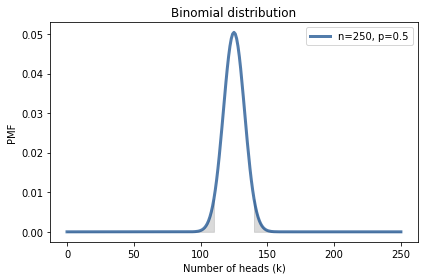

In [ ]:
import matplotlib.pyplot as plt

def fill_below(pmf):
    qs = pmf.index
    ps = pmf.values
    plt.fill_between(qs, ps, 0, color='C5', alpha=0.4)

qs = pmf_k.index
fill_below(pmf_k[qs>=140])
fill_below(pmf_k[qs<=110])
pmf_k.plot(label='n=250, p=0.5')

decorate(xlabel='Number of heads (k)',
         ylabel='PMF',
         title='Binomial distribution')

Here's how we compute the total probability of the left tail.

In [ ]:
pmf_k.prob_le(110)

0.03321057562002164

The probability of outcomes less than or equal to 110 is also 3.3%, so the total probability of outcomes "as extreme" as 140 is 6.6%.

The point of this calculation is that these extreme outcomes are unlikely if the coin is fair.

Bayesian Estimation



Any given coin has some probability of landing heads up when spun on edge; I'll call this probability x. It seems reasonable to believe that x depends on physical characteristics of the coin, like the distribution of weight. If a coin is perfectly balanced, we expect x to be close to 50%, but for a lopsided coin, x might be substantially different. We can use Bayes's theorem and the observed data to estimate x.

For simplicity, I'll start with a uniform prior, which assumes that all values of x are equally likely. That might not be a reasonable assumption, so we'll come back and consider other priors later.

In [ ]:
hypos = np.linspace(0, 1, 101)
prior = Pmf(1, hypos)

We can use the hypotheses to compute the likelihoods, like this:

In [ ]:
likelihood_heads = hypos
likelihood_tails = 1 - hypos

I'll put the likelihoods for heads and tails in a dictionary to make it easier to do the update.

In [ ]:
likelihood = {
    'H': likelihood_heads,
    'T': likelihood_tails
}

To represent the data, I'll construct a string with H repeated 140 times and T repeated 110 times.

In [ ]:
dataset = 'H' * 140 + 'T' * 110

The following function does the update.

In [ ]:
def update_euro(pmf, dataset):
    """Update pmf with a given sequence of H and T."""
    for data in dataset:
        pmf *= likelihood[data]

    pmf.normalize()

In [ ]:
posterior = prior.copy()
update_euro(posterior, dataset)

And here's what the posterior looks like.

In [ ]:
def decorate_euro(title):
    decorate(xlabel='Proportion of heads (x)',
             ylabel='Probability',
             title=title)

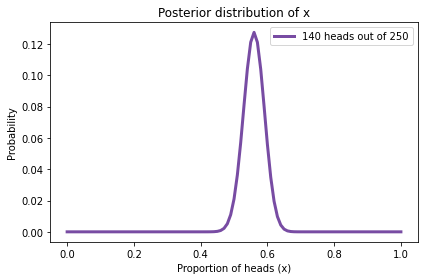

In [ ]:
posterior.plot(label='140 heads out of 250', color='C4')
decorate_euro(title='Posterior distribution of x')

In [ ]:
posterior.max_prob()

0.56

The posterior distribution represents our beliefs about x after seeing the data. It indicates that values less than 0.4 and greater than 0.7 are unlikely; values between 0.5 and 0.6 are the most likely.

Triangle Prior

In [ ]:
uniform = Pmf(1, hypos, name='uniform')
uniform.normalize()

101

But that might not be a reasonable choice based on what we know about coins. I can believe that if a coin is lopsided, x might deviate substantially from 0.5, but it seems unlikely that the Belgian Euro coin is so imbalanced that x is 0.1 or 0.9.

It might be more reasonable to choose a prior that gives higher probability to values of x near 0.5 and lower probability to extreme values.

As an example, let's try a triangle-shaped prior. Here's the code that constructs it:

In [ ]:
ramp_up = np.arange(50)
ramp_down = np.arange(50, -1, -1)

a = np.append(ramp_up, ramp_down)

triangle = Pmf(a, hypos, name='triangle')
triangle.normalize()

2500

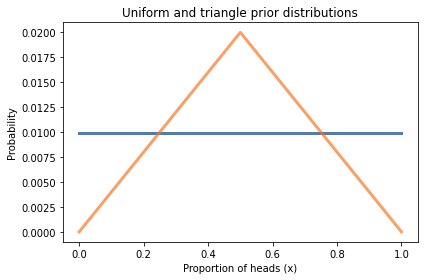

In [ ]:
uniform.plot()
triangle.plot()
decorate_euro(title='Uniform and triangle prior distributions')


Now we can update both priors with the same data:

In [ ]:
update_euro(uniform, dataset)
update_euro(triangle, dataset)

Here are the posteriors.

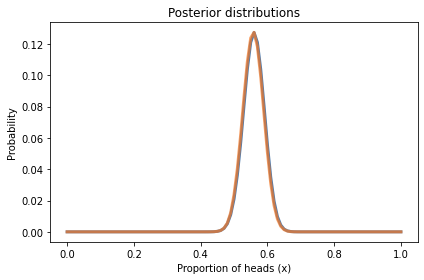

In [ ]:
uniform.plot()
triangle.plot()
decorate_euro(title='Posterior distributions')

The Binomial Likelihood Function

In [ ]:
from scipy.stats import binom

def update_binomial(pmf, data):
    """Update pmf using the binomial distribution."""
    k, n = data
    xs = pmf.qs
    likelihood = binom.pmf(k, n, xs)
    pmf *= likelihood
    pmf.normalize()

In [ ]:
uniform2 = Pmf(1, hypos, name='uniform2')
data = 140, 250
update_binomial(uniform2, data)

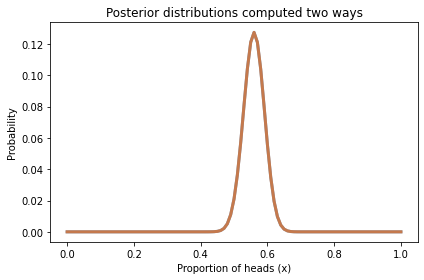

In [ ]:
uniform.plot()
uniform2.plot()
decorate_euro(title='Posterior distributions computed two ways')

For this exercise, I'll construct the prior distribution by starting with a uniform distribution and updating it with imaginary data until it has a shape that reflects my background knowledge of batting averages.

In [ ]:
hypos = np.linspace(0.1, 0.4, 101)
prior = Pmf(1, hypos)

And here is a dictionary of likelihoods, with Y for getting a hit and N for not getting a hit.

In [ ]:
likelihood = {
    'Y': hypos,
    'N': 1-hypos
}

Here's a dataset that yields a reasonable prior distribution.

In [ ]:
dataset = 'Y' * 25 + 'N' * 75

And here's the update with the imaginary data.

In [ ]:
for data in dataset:
    prior *= likelihood[data]

prior.normalize()

1.3596964206970507e-23

prior looks like:-

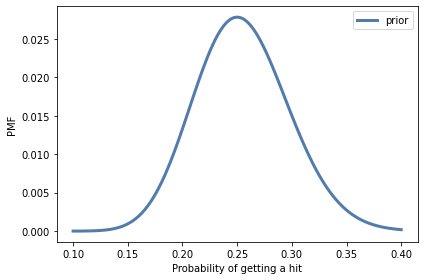

In [ ]:
prior.plot(label='prior')
decorate(xlabel='Probability of getting a hit',
         ylabel='PMF')